<a href="https://colab.research.google.com/github/nori0724/forecast_PM2.5/blob/master/predict_all_LSTM1118.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
import datetime


In [0]:
df=pd.read_csv("china_pm2.5.csv")

In [72]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
df.drop("No", axis=1, inplace=True)

In [0]:
df["datetime"]=df.year.astype("str")+"-"+df.month.astype("str")+ "-" +df.day.astype("str")+" "+df.hour.astype("str")+":00:00"


In [0]:
df.index=df["datetime"]

In [0]:
df.drop("datetime", axis=1, inplace=True)

In [0]:
 df["pm2.5"].fillna(0, inplace=True)

In [0]:
df=df[24:]

In [79]:
df.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,,,,,
2010-1-2 0:00:00,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-1-2 1:00:00,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-1-2 2:00:00,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-1-2 3:00:00,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-1-2 4:00:00,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [80]:
df.tail()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,,,,,
2014-12-31 19:00:00,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
2014-12-31 22:00:00,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0
2014-12-31 23:00:00,2014,12,31,23,12.0,-21,-3.0,1034.0,NW,249.85,0,0


In [0]:
values=df.values

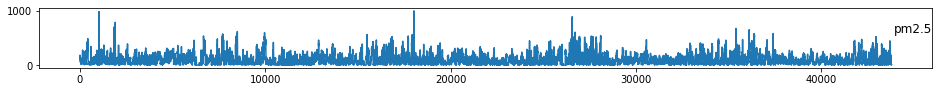

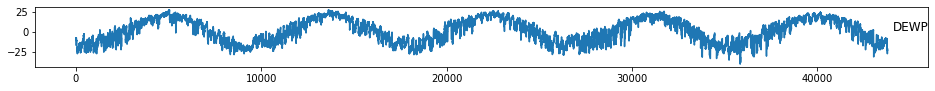

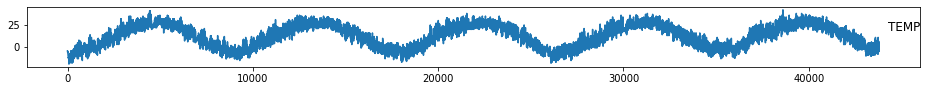

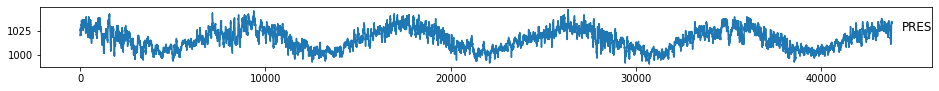

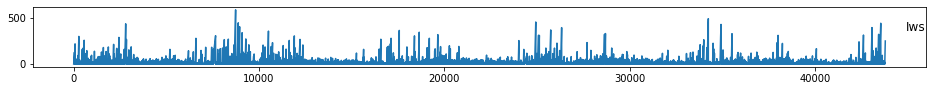

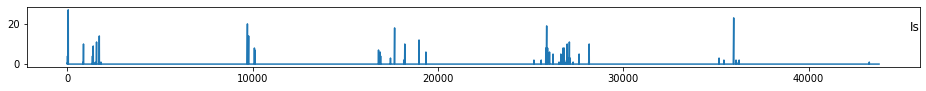

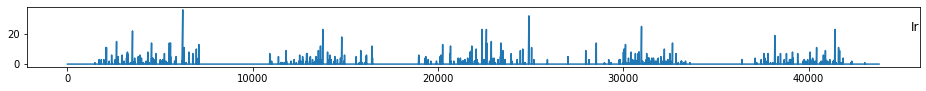

In [82]:
cols=[4, 5, 6 ,7 ,9, 10, 11]

i=1
for col in cols:
  plt.figure(figsize=(16,9))
  plt.subplot(len(cols), 1, i)
  plt.plot(values[:,col])
  plt.title(df.columns[col], y=0.5, loc="right")
  i+=1
plt.show()

In [0]:
###特徴量作成

In [84]:
df.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,,,,,
2010-1-2 0:00:00,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-1-2 1:00:00,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-1-2 2:00:00,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-1-2 3:00:00,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-1-2 4:00:00,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [0]:
tmp=pd.get_dummies(df["cbwd"].astype("str"))

df=pd.concat([df, tmp], axis=1)

df.drop("cbwd", axis=1, inplace=True)

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
#なんでもいい
forecasttime=12
#過去の特徴量の数
num_feature=12
X = series_to_supervised(df, num_feature, forecasttime)

In [0]:
  y = []
  for i in range(len(df)-num_feature-forecasttime+1):
    target=df["pm2.5"].values
    b=target[(i + num_feature):(i + num_feature + forecasttime)]
    y.append(b)

In [0]:
#np.arrayに変更
X=X.values
y=np.array(y)

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)

In [232]:
print(int(len(X)*0.8))

35030


In [0]:
length=int(len(X)*0.8)
trainX=X[:length]
trainY=y[:length]

testX=X[length:-num_feature+1]
testY=y[length:]

In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [238]:
print(trainX.shape)
print(trainY.shape)

print(testX.shape)
print(testY.shape)

(35030, 1, 180)
(35030, 12)
(8747, 1, 180)
(8747, 12)


In [0]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(40, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.25))
model.add(Dense(trainY.shape[1]))


In [240]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=128, verbose=2)

Epoch 1/200
 - 3s - loss: 0.0066
Epoch 2/200
 - 1s - loss: 0.0043
Epoch 3/200
 - 1s - loss: 0.0039
Epoch 4/200
 - 1s - loss: 0.0038
Epoch 5/200
 - 1s - loss: 0.0037
Epoch 6/200
 - 1s - loss: 0.0036
Epoch 7/200
 - 1s - loss: 0.0035
Epoch 8/200
 - 1s - loss: 0.0035
Epoch 9/200
 - 1s - loss: 0.0034
Epoch 10/200
 - 1s - loss: 0.0034
Epoch 11/200
 - 1s - loss: 0.0034
Epoch 12/200
 - 1s - loss: 0.0033
Epoch 13/200
 - 1s - loss: 0.0033
Epoch 14/200
 - 1s - loss: 0.0033
Epoch 15/200
 - 1s - loss: 0.0033
Epoch 16/200
 - 1s - loss: 0.0032
Epoch 17/200
 - 1s - loss: 0.0032
Epoch 18/200
 - 1s - loss: 0.0031
Epoch 19/200
 - 1s - loss: 0.0031
Epoch 20/200
 - 1s - loss: 0.0031
Epoch 21/200
 - 1s - loss: 0.0031
Epoch 22/200
 - 1s - loss: 0.0031
Epoch 23/200
 - 1s - loss: 0.0031
Epoch 24/200
 - 1s - loss: 0.0030
Epoch 25/200
 - 1s - loss: 0.0030
Epoch 26/200
 - 1s - loss: 0.0030
Epoch 27/200
 - 1s - loss: 0.0030
Epoch 28/200
 - 1s - loss: 0.0030
Epoch 29/200
 - 1s - loss: 0.0030
Epoch 30/200
 - 1s - lo

In [0]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [242]:
print(trainPredict.shape)
print(testPredict.shape)
print(X.shape)
print(X.shape)

(35030, 12)
(8747, 12)
(43788, 180)
(43788, 180)


In [0]:
pad_col = np.zeros(trainPredict.shape[1]-num_feature)
def pad_array(val):
    return np.array([np.insert(pad_col, 0, x) for x in val])

trainPredict = scaler.inverse_transform(pad_array(trainPredict))
trainY = scaler.inverse_transform(pad_array(trainY))
testPredict = scaler.inverse_transform(pad_array(testPredict))
testY = scaler.inverse_transform(pad_array(testY))

In [244]:
print(trainPredict.shape)
print(testPredict.shape)
print(X.shape)

(35030, 12)
(8747, 12)
(43788, 180)


In [245]:
from sklearn.metrics import r2_score
print(r2_score(trainPredict, trainY))

0.6349104608817475


In [246]:
from sklearn.metrics import r2_score
r2_score(testPredict, testY)

0.3144341179183923

In [247]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(trainPredict[0:,0], trainY[0:,0])))
print(np.sqrt(mean_squared_error(trainPredict[:,1], trainY[:,1])))
print(np.sqrt(mean_squared_error(trainPredict[:,2], trainY[:,2])))

27.920943227229493
33.97298563239193
38.02286939722745


In [0]:
#######可視化

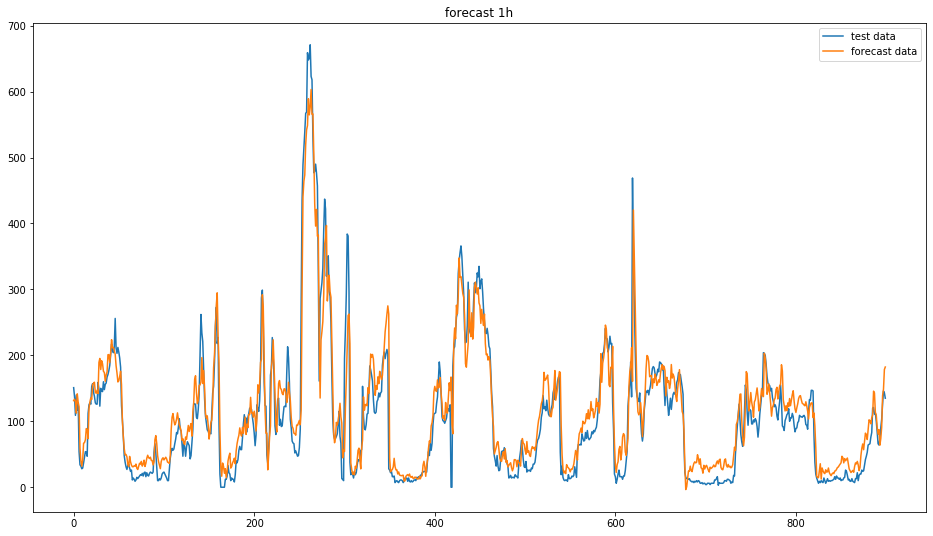

In [250]:
#予測したい時間
plt.figure(figsize=(16,9))
plt.plot(testY[100:1000,0], label="test data")
plt.plot(testPredict[100:1000,0], label="forecast data")
plt.title("forecast 1h")
plt.legend()

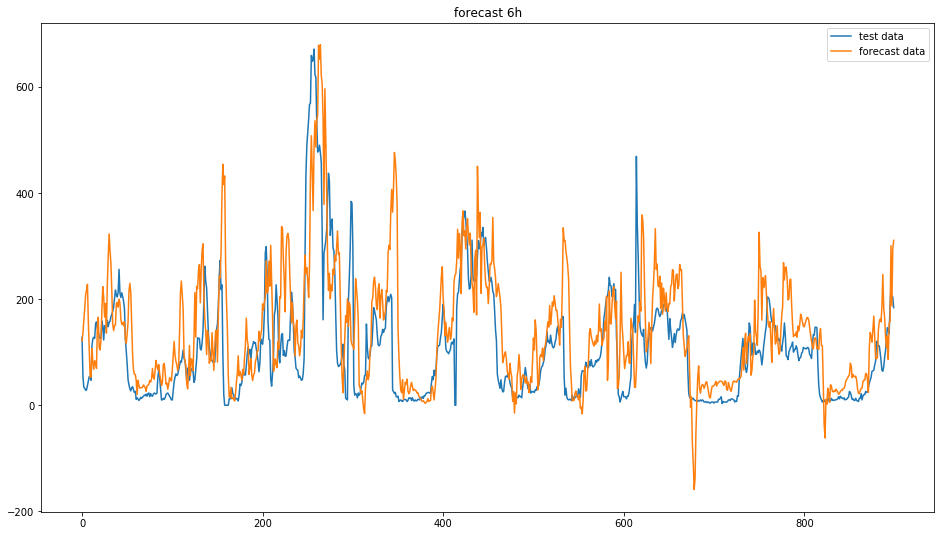

In [251]:
#予測したい時間
plt.figure(figsize=(16,9))
plt.plot(testY[100:1000,5], label="test data")
plt.plot(testPredict[100:1000,5], label="forecast data")
plt.title("forecast 6h")
plt.legend()

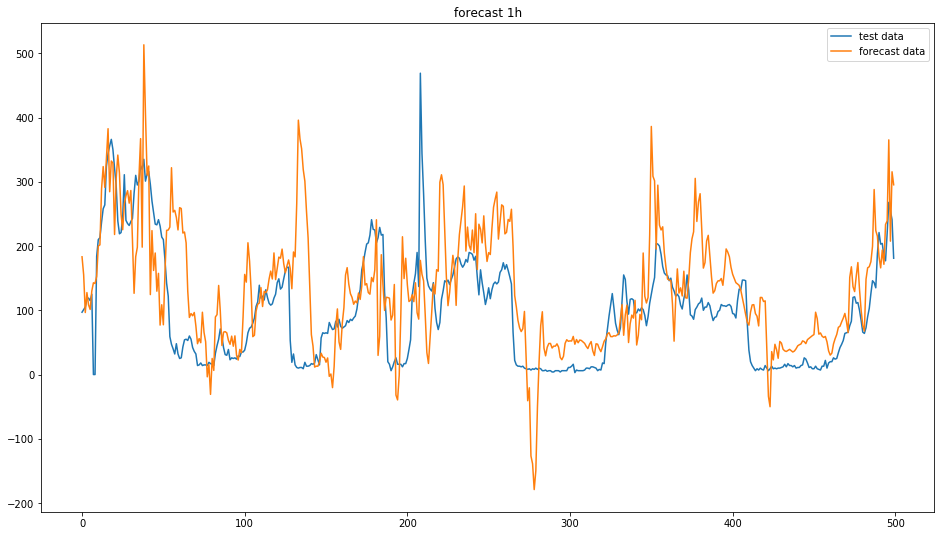

In [252]:
#予測したい時間
plt.figure(figsize=(16,9))
plt.plot(testY[500:1000,11], label="test data")
plt.plot(testPredict[500:1000,11], label="forecast data")
plt.title("forecast 1h")
plt.legend()

In [254]:
#元データに代入
#リークしてないか確認
tmp0=df[len(trainY)+12:-11]
tmp0["forecast_pm2.5"]=list(testPredict[:,0])
tmp0["actual_pm2.5"]=list(testY[:,0])

tmp1=df[len(trainY)+12+1:-11+1]
tmp1["forecast_pm2.5"]=list(testPredict[:,1])
tmp1["actual_pm2.5"]=list(testY[:,1])

tmp2=df[len(trainY)+12+2:-11+2]
tmp2["forecast_pm2.5"]=list(testPredict[:,2])
tmp2["actual_pm2.5"]=list(testY[:,2])

tmp3=df[len(trainY)+12+3:-11+3]
tmp3["forecast_pm2.5"]=list(testPredict[:,3])
tmp3["actual_pm2.5"]=list(testY[:,3])

tmp4=df[len(trainY)+12+4:-11+4]
tmp4["forecast_pm2.5"]=list(testPredict[:,4])
tmp4["actual_pm2.5"]=list(testY[:,4])

tmp5=df[len(trainY)+12+5:-11+5]
tmp5["forecast_pm2.5"]=list(testPredict[:,5])
tmp5["actual_pm2.5"]=list(testY[:,5])

tmp6=df[len(trainY)+12+6:-11+6]
tmp6["forecast_pm2.5"]=list(testPredict[:,6])
tmp6["actual_pm2.5"]=list(testY[:,6])

tmp7=df[len(trainY)+12+7:-11+7]
tmp7["forecast_pm2.5"]=list(testPredict[:,7])
tmp7["actual_pm2.5"]=list(testY[:,7])

tmp8=df[len(trainY)+12+8:-11+8]
tmp8["forecast_pm2.5"]=list(testPredict[:,8])
tmp8["actual_pm2.5"]=list(testY[:,8])

tmp9=df[len(trainY)+12+9:-11+9]
tmp9["forecast_pm2.5"]=list(testPredict[:,9])
tmp9["actual_pm2.5"]=list(testY[:,9])

tmp10=df[len(trainY)+12+10:-11+10]
tmp10["forecast_pm2.5"]=list(testPredict[:,10])
tmp10["actual_pm2.5"]=list(testY[:,10])

tmp11=df[len(trainY)+12+11:]
tmp11["forecast_pm2.5"]=list(testPredict[:,11])
tmp11["actual_pm2.5"]=list(testY[:,11])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [0]:
def modify_minus(x):
  if x<0:
    return np.nan
  else:
    return x

In [256]:
#pm2.5の値をマイナスと予測してしまったところを欠損値として扱う
#その後前後の値で補完
tmp0["forecast_pm2.5"]=tmp0["forecast_pm2.5"].apply(lambda x:modify_minus(x)).interpolate(axis=0)
tmp1["forecast_pm2.5"]=tmp1["forecast_pm2.5"].apply(lambda x:modify_minus(x)).interpolate(axis=0)
tmp2["forecast_pm2.5"]=tmp2["forecast_pm2.5"].apply(lambda x:modify_minus(x)).interpolate(axis=0)
tmp3["forecast_pm2.5"]=tmp3["forecast_pm2.5"].apply(lambda x:modify_minus(x)).interpolate(axis=0)
tmp4["forecast_pm2.5"]=tmp4["forecast_pm2.5"].apply(lambda x:modify_minus(x)).interpolate(axis=0)
tmp5["forecast_pm2.5"]=tmp5["forecast_pm2.5"].apply(lambda x:modify_minus(x)).interpolate(axis=0)
tmp6["forecast_pm2.5"]=tmp6["forecast_pm2.5"].apply(lambda x:modify_minus(x)).interpolate(axis=0)
tmp7["forecast_pm2.5"]=tmp7["forecast_pm2.5"].apply(lambda x:modify_minus(x)).interpolate(axis=0)
tmp8["forecast_pm2.5"]=tmp8["forecast_pm2.5"].apply(lambda x:modify_minus(x)).interpolate(axis=0)
tmp9["forecast_pm2.5"]=tmp9["forecast_pm2.5"].apply(lambda x:modify_minus(x)).interpolate(axis=0)
tmp10["forecast_pm2.5"]=tmp10["forecast_pm2.5"].apply(lambda x:modify_minus(x)).interpolate(axis=0)
tmp11["forecast_pm2.5"]=tmp11["forecast_pm2.5"].apply(lambda x:modify_minus(x)).interpolate(axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [0]:
def category(x):
  if x>=0 and x<=50 :
    return "Good"
  elif x>50 and x<=100:
    return "Moderate"
  elif x>100 and x<=200:
    return "Poor"
  elif x>200 and x<=300:
    return "Unhealthy"
  elif x>300 and x<=400:
    return "Severe"
  else:
    return "Hazardous"

In [258]:
#カテゴリに変換
tmp0["forecast_category"]=tmp0["forecast_pm2.5"].apply(lambda x:category(x))
tmp0["actual_category"]=tmp0["actual_pm2.5"].apply(lambda x:category(x))

tmp1["forecast_category"]=tmp1["forecast_pm2.5"].apply(lambda x:category(x))
tmp1["actual_category"]=tmp1["actual_pm2.5"].apply(lambda x:category(x))

tmp2["forecast_category"]=tmp2["forecast_pm2.5"].apply(lambda x:category(x))
tmp2["actual_category"]=tmp2["actual_pm2.5"].apply(lambda x:category(x))

tmp3["forecast_category"]=tmp3["forecast_pm2.5"].apply(lambda x:category(x))
tmp3["actual_category"]=tmp3["actual_pm2.5"].apply(lambda x:category(x))

tmp4["forecast_category"]=tmp4["forecast_pm2.5"].apply(lambda x:category(x))
tmp4["actual_category"]=tmp4["actual_pm2.5"].apply(lambda x:category(x))

tmp5["forecast_category"]=tmp5["forecast_pm2.5"].apply(lambda x:category(x))
tmp5["actual_category"]=tmp5["actual_pm2.5"].apply(lambda x:category(x))

tmp6["forecast_category"]=tmp6["forecast_pm2.5"].apply(lambda x:category(x))
tmp6["actual_category"]=tmp6["actual_pm2.5"].apply(lambda x:category(x))

tmp7["forecast_category"]=tmp7["forecast_pm2.5"].apply(lambda x:category(x))
tmp7["actual_category"]=tmp7["actual_pm2.5"].apply(lambda x:category(x))

tmp8["forecast_category"]=tmp8["forecast_pm2.5"].apply(lambda x:category(x))
tmp8["actual_category"]=tmp8["actual_pm2.5"].apply(lambda x:category(x))

tmp9["forecast_category"]=tmp9["forecast_pm2.5"].apply(lambda x:category(x))
tmp9["actual_category"]=tmp9["actual_pm2.5"].apply(lambda x:category(x))

tmp10["forecast_category"]=tmp10["forecast_pm2.5"].apply(lambda x:category(x))
tmp10["actual_category"]=tmp10["actual_pm2.5"].apply(lambda x:category(x))

tmp11["forecast_category"]=tmp11["forecast_pm2.5"].apply(lambda x:category(x))
tmp11["actual_category"]=tmp11["actual_pm2.5"].apply(lambda x:category(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [259]:
from sklearn.metrics import accuracy_score
print("------------------------------------------")
print("1時間後の精度")
print(accuracy_score(tmp0["actual_category"], tmp0[ "forecast_category"]))
print("------------------------------------------")
print("2時間後の精度")
print(accuracy_score(tmp1["actual_category"], tmp1[ "forecast_category"]))
print("------------------------------------------")
print("3時間後の精度")
print(accuracy_score(tmp2["actual_category"], tmp2[ "forecast_category"]))
print("------------------------------------------")
print("4時間後の精度")
print(accuracy_score(tmp3["actual_category"], tmp3[ "forecast_category"]))
print("------------------------------------------")
print("5時間後の精度")
print(accuracy_score(tmp4["actual_category"], tmp4[ "forecast_category"]))
print("------------------------------------------")
print("6時間後の精度")
print(accuracy_score(tmp5["actual_category"], tmp5[ "forecast_category"]))
print("------------------------------------------")
print("7時間後の精度")
print(accuracy_score(tmp6["actual_category"], tmp6[ "forecast_category"]))
print("------------------------------------------")
print("8時間後の精度")
print(accuracy_score(tmp7["actual_category"], tmp7[ "forecast_category"]))
print("------------------------------------------")
print("9時間後の精度")
print(accuracy_score(tmp8["actual_category"], tmp8[ "forecast_category"]))
print("------------------------------------------")
print("10時間後の精度")
print(accuracy_score(tmp9["actual_category"], tmp9[ "forecast_category"]))
print("------------------------------------------")
print("11時間後の精度")
print(accuracy_score(tmp10["actual_category"], tmp10[ "forecast_category"]))
print("------------------------------------------")
print("12時間後の精度")
print(accuracy_score(tmp11["actual_category"], tmp11[ "forecast_category"]))

------------------------------------------
1時間後の精度
0.7106436492511718
------------------------------------------
2時間後の精度
0.661140962615754
------------------------------------------
3時間後の精度
0.6254715902595176
------------------------------------------
4時間後の精度
0.5867154452955299
------------------------------------------
5時間後の精度
0.5503601234709043
------------------------------------------
6時間後の精度
0.5253229678746999
------------------------------------------
7時間後の精度
0.5028009603292557
------------------------------------------
8時間後の精度
0.476963530353264
------------------------------------------
9時間後の精度
0.46278724133988797
------------------------------------------
10時間後の精度
0.44506688007316797
------------------------------------------
11時間後の精度
0.4346633131359323
------------------------------------------
12時間後の精度
0.4133988796158683
